In [1]:
"""
심화 학습: 다양체 학습

PCA가 유연하고 빠르며 쉽게 해석 가능하지만, 데이터 내에서 비선형적인 관계가 있을 때는
그렇게 잘 동작하지 않는다
이 결점을 해결하기 위해 고차원 공간에 내장된 저차원 다양체로 데이터세트를 설명하고자 하는
비지도 추정방식인 다양체 학습(manifold learning)이라는 방식을 고려할 수 있다

다양체를 생각할 때는 한 장의 종이를 상상해 보면 좋다 => 익숙한 3차원 세계에 존재하면서도 2차원으로
접거나 구부릴 수 있는 2차원의 객체
3차원 공간에서 종잇조각을 회전하거나 방향을 바꾸거나 편다고 해서 종이의 평평한 기하학적 구조가 바뀌지 않는다

다양체 학습 알고리즘은 종이를 3차원공간을 채우도록 뒤틀어 놓았더라도 종이가 가진 기본적인 2차원 속성에
대해 학습하려고 한다

1 - 다차원 척도법(MDS, multidimensional scaling)
2 - 국부 선형 임베딩(LLE, locally linear embedding)
3 - 등거리 사상(Isomap, isometric mapping)
"""

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, seaborn as sns; sns.set()

In [2]:
# 다양체 학습: "HELLO"
# 2차원 데이터, 단어 "HELLO"라는 모양의 데이터를 생성하는 함수
def make_hello(N=1000, rseed=42):
    # "HELLO" 텍스트로 플로팅해서 PNG 파일로 저장
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis("off")
    ax.text(0.5, 0.4, "HELLO", va="center", ha="center", weight="bold", size=85)
    fig.savefig("hello.png")
    plt.close(fig)
    
    # 이 PNG 파일을 열어 임의의 점을 추출
    from matplotlib.image import imread
    data = imread("hello.png")[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    
    return X[np.argsort(X[:, 0])]

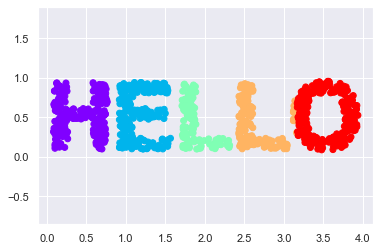

In [3]:
X = make_hello(1000)
colorsize = dict(c=X[:, 0], cmap=plt.cm.get_cmap("rainbow", 5))
plt.scatter(X[:, 0], X[:, 1], **colorsize)
plt.axis("equal");

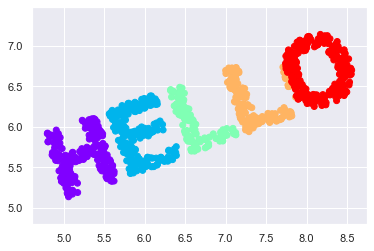

In [4]:
# 다차원 척도법(MDS, multidimensional scaling)
# 가령 회전 행렬(rotation matrix)을 사용해 데이터를 회전하면 x와 y값이 바뀌지만 그 데이터는 기본적으로 동일
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorsize)
plt.axis("equal");

# x와 y 값이 데이터의 관계에 있어 근본적인 것은 아니라는 사실
# 근본적인 것은 데이터세트의 점과 점 사이의 거리

In [5]:
# 거리 행렬(distance matrix)
# N개의 점에 대해 NxN 행렬을 구성해 (i, j) 항목에 점 i와 점 j 사이의 거리를 포함
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

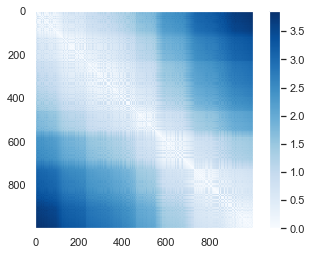

In [6]:
plt.imshow(D, zorder=2, cmap="Blues", interpolation="nearest")
plt.colorbar();

In [7]:
# 두 거리 행렬이 동일함
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

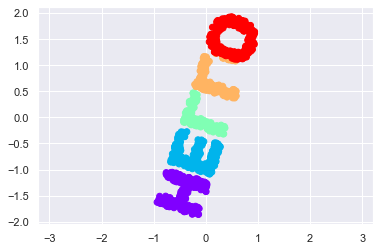

In [8]:
# precomputed 비유사성을 사용해 거리 행렬을 전달하는 것으로 지정해 이 알고리즘이
# 거리 행렬에 대해 어떻게 동작하는지 보기
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorsize)
plt.axis("equal");

# MDS 알고리즘은 데이터 점 사이의 관계를 설명하는 NxN 거리 행렬만을 사용해 사용 가능한 2차원 좌표 표현 중 하나를 복구

In [9]:
# 다양체 학습으로서의 MDS
# 2차원 평면에서 단순히 회전하는 대신 다음 함수를 3차원에 사영
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

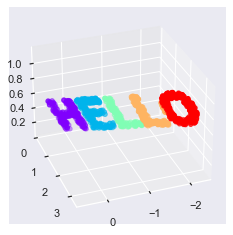

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection="3d")
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], **colorsize)
ax.view_init(azim=70, elev=30)

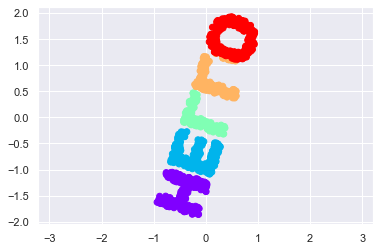

In [11]:
# MDS 추정기에 3차원 데이터를 입력 => 거리 행렬 계산 => 최적의 2차원 임베딩 결정
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out[:, 1], **colorsize)
plt.axis("equal");

"""
고차원의 임베딩된 데이터가 주어졌을 때 다양체 학습이 데이터 내의 특정 관계를 보존하는 데이터의 저차원 표현
MDS의 경우, 보존된 양은 각 쌍의 점 사이의 거리
""";

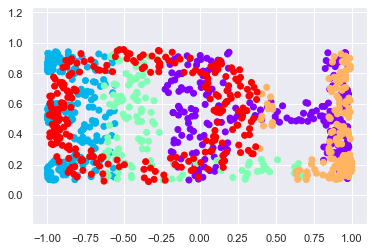

In [12]:
# 비선형 임베딩: MDS가 실패한 경우
# 입력값을 취해 그것을 3차원의 "S" 모양에 뒤틀어 넣기
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

plt.scatter(XS[:, 0], XS[:, 1], **colorsize);
plt.axis("equal");

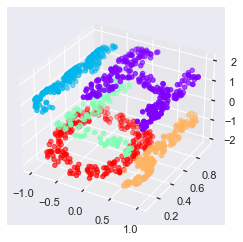

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection="3d")
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorsize);

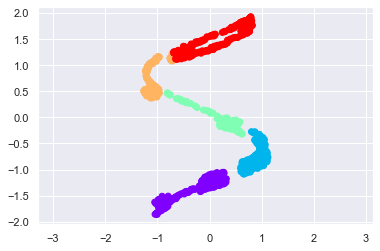

In [14]:
# 간단한 MDS 알고리즘을 적용하면 이 비선형 임베딩을 풀 수 없고 임베딩된 다양체의 근본적인 관계를 추적할 수 없게 된다
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], out[:, 1], **colorsize)
plt.axis("equal");

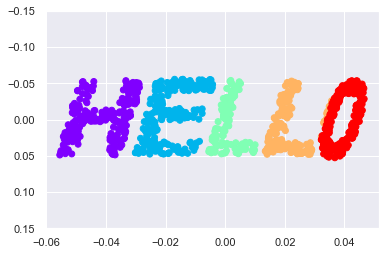

In [15]:
# 비선형 다양체 학습: 국소 선형 임베딩 (LLE, locally linear embedding)
# 가까이 있는 점들 사이의 거리만 보존하도록 알고리즘을 수정
# 일반적으로 수정 LLE는 매우 적은 왜곡으로 잘 정의된 다양체를 복구하는데 있어 뛰어나다
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2,
                               method="modified", eigen_solver="dense")

out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorsize)
ax.set_ylim(0.15, -0.15);

In [16]:
# 예제: 얼굴 데이터에 아이소맵(Isomap) 적용
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

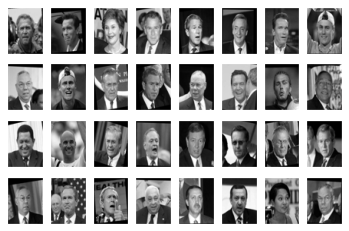

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap="gray")

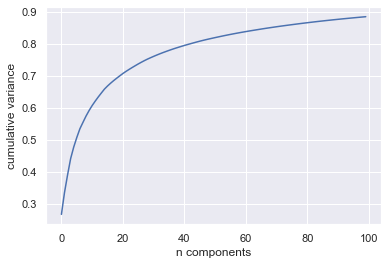

In [18]:
# 2914차원 데이터의 저차원 임베딩을 플로팅
# PCA를 계산하고 설명 분산 비율을 ㅗ학인해서 데이터를 설명하기 위해 얼마나 많은 선형 특징이 필요한지 알아보기
from sklearn.decomposition import PCA
model = PCA(n_components=100, svd_solver="randomized").fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative variance");

# 데이터 분산의 90%를 보존하기 위해서 100개의 성분이 필요하다
# 본질적으로 매우 높은 차원의 데이터는 단지 몇 개의 성분만 가지고 선형적으로 설명될 수 없음

In [19]:
# 얼굴들에 대한 Isomap 임베딩을 계산
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [20]:
# 사영의 위치에 이미지 섬네일을 출력하는 함수를 정의
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap="gray"):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], ".k")
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 너무 가까운 점들은 보여주지 말 것
                continue
            
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

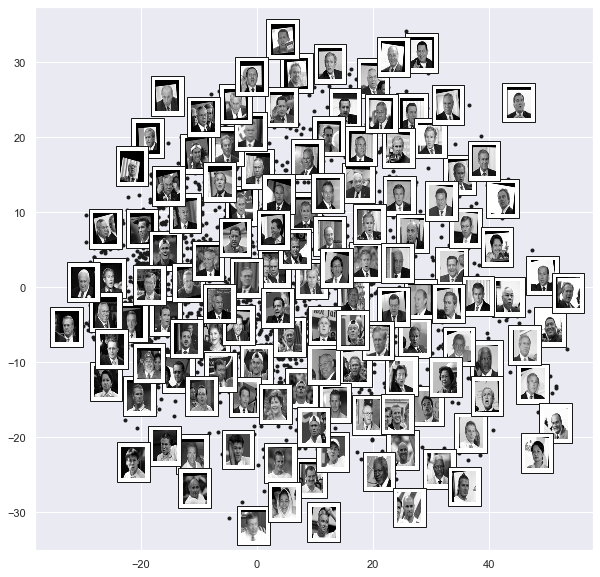

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

In [22]:
# 예제: 숫자 데이터의 구조 시각화
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")
mnist.data.shape

(70000, 784)

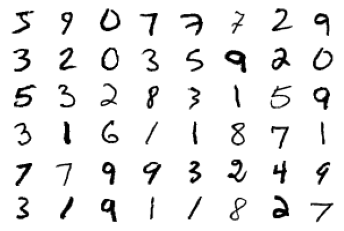

In [24]:
import pandas as pd
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(pd.Series.to_numpy(mnist.data.iloc[1250 * i]).reshape(28, 28), cmap="gray_r")

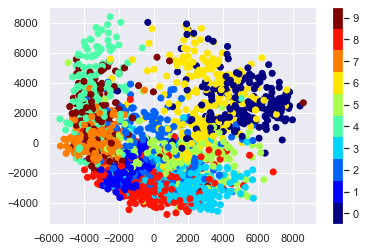

In [25]:
"""
다양체 학습은 비교적 확장성이 약하기 때문에 전체 계산을 하기 전
상대적으로 빨리 탐색하기 위해 2~3천 개의 표본에 먼저 적용해 보는 것이 좋다
"""

# 데이터의 1/30만 사용, 전체 데이터세트를 계산하려면 시간이 오래 걸림
data = mnist.data[::30] # skip every 30 data points
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target.astype(int), cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

# 데이터 점들 사이의 관계를 보여주기는 하지만 다소 붐빈다

In [26]:
# 한 번에 하나의 숫자만 살펴보면 더 많은 통찰력을 얻을 수 있다